In [17]:
import pandas as pd
import matplotlib.pyplot as plt

3. Greeks measure the sensitivity of the price of derivatives to a change in underlying asset’s parameters. They are used for hedging and risk
management. The commonly used greeks (risk sensitivities) are:
    * Delta $\Delta = \frac{\partial V}{\partial S}$: measures the rate of change of the option value with respect to changes in the underlying asset's price.
    * Gamma $\Gamma = \frac{\partial^2 V}{\partial S^2} = \frac{\partial \Delta}{\partial S}$: measures the rate of change of delta with respect to changes in the underlying asset's price.
    * Vega: $v = \frac{\partial V}{\partial \sigma}$: measures the rate of change of the option value with respect to changes in the underlying asset's volatility.
    * Theta: $\theta = \frac{\partial V}{\partial t}$: the rate of change in the price of an option with respect to pricing time. Note that we normally use $t$ to represent pricing time, $T$ to represent expiry time, time to expiry in our pricer is $T-t$. In the implementation of the pricers that take time to expiry as an argument, we implicitly set pricing time to 0 (present).
    * Rho: the rate of change in the price of an option in response to a change in the interest rate.

  The greeks are normally not known in closed form since numerical pricers are used. They are approximated by finite differences:

  \begin{align}
    & \Delta = \frac{\partial V}{\partial S} \approx \frac{V(S + \Delta S) - V(S-\Delta S)}{2 \Delta S}, ~~~\Delta S = 0.1\% S \\
    & \Gamma = \frac{\partial V^2}{\partial S^2} \approx \frac{V(S + \Delta S) - 2V(S) + V(S-\Delta S)}{\Delta S^2} \\
    & v = \frac{\partial V}{\partial \sigma} \approx \frac{V(S, \sigma +\Delta \sigma) - V(S, \sigma -\Delta \sigma)}{2 \Delta \sigma } ~~~~~~~\Delta \sigma = 0.1\% \\
    & \theta = \frac{\partial V}{\partial t} \approx \frac{V(S, t+\Delta t, T) - V(S, t, T)}{\Delta t} ~~~~\Delta t = 0.004 \\
    & \rho = \frac{\partial V}{\partial r} \approx \frac{V(S, r+\Delta r) - V(S, r - \Delta r)}{2 \Delta r}  ~~~~~\Delta r = 0.0001
  \end{align}

  Implement a Greeks calculater for binomial tree pricer provided below. The signature of the greeks calculator is
      ```python
      def binomialGreeks(S, r, vol, T, strike, greekType) -> float
      ```
  Setting $S = 100, r = 0.03, vol = 0.2$, plot each greeks as a function of strike for 1 year European call option with strike from 50 to 150. Play with different binomial models and see if there is any difference.
  
  Note that in practice, the greeks are rescaled with a pre-defined scaler, so that they give a sense of how much PV (Delta) changes with a typical move of the market. The rescaling is not incorporated in this exercise.

In [68]:
import time
import timeit
from enum import Enum
import math
import matplotlib.pyplot as plt
import numpy as np

# one step binomial
from enum import Enum
import math

# binomial pricer for exercise 3
class PayoffType(str, Enum):
    Call = 'Call'
    Put = 'Put'
    
class EuropeanOption():
    def __init__(self, expiry, strike, payoffType):
        self.expiry = expiry
        self.strike = strike
        self.payoffType = payoffType
    def payoff(self, S):
        if self.payoffType == PayoffType.Call:
            return max(S - self.strike, 0)
        elif self.payoffType == PayoffType.Put:
            return max(self.strike - S, 0)
        else:
            raise Exception("payoffType not supported: ", self.payoffType)
    def valueAtNode(self, t, S, continuation):
        return continuation

class AmericanOption():
    def __init__(self, expiry, strike, payoffType):
        self.expiry = expiry
        self.strike = strike
        self.payoffType = payoffType
    def payoff(self, S):
        if self.payoffType == PayoffType.Call:
            return max(S - self.strike, 0)
        elif self.payoffType == PayoffType.Put:
            return max(self.strike - S, 0)
        else:
            raise Exception("payoffType not supported: ", self.payoffType)
    def valueAtNode(self, t, S, continuation):
        return max(self.payoff(S), continuation)

def crrCalib(r, vol, t):
    b = math.exp(vol * vol * t + r * t) + math.exp(-r * t)
    u = (b + math.sqrt(b * b - 4)) / 2
    p = (math.exp(r * t) - (1 / u)) / (u - 1 / u)
    return (u, 1/u, p)

def jrrnCalib(r, vol, t):
    u = math.exp((r - vol * vol / 2) * t + vol * math.sqrt(t))
    d = math.exp((r - vol * vol / 2) * t - vol * math.sqrt(t))
    p = (math.exp(r * t) - d) / (u - d)
    return (u, d, p)

def jreqCalib(r, vol, t):
    u = math.exp((r - vol * vol / 2) * t + vol * math.sqrt(t))
    d = math.exp((r - vol * vol / 2) * t - vol * math.sqrt(t))
    return (u, d, 1/2)

def tianCalib(r, vol, t):
    v = math.exp(vol * vol * t)
    u = 0.5 * math.exp(r * t) * v * (v + 1 + math.sqrt(v*v + 2*v - 3))
    d = 0.5 * math.exp(r * t) * v * (v + 1 - math.sqrt(v*v + 2*v - 3))
    p = (math.exp(r * t) - d) / (u - d)
    return (u, d, p)

def binomialPricer(S, r, vol, trade, n, calib, manual_t=None):
    t = manual_t if manual_t is not None else trade.expiry / n
# def binomialPricer(S, r, vol, trade, n, calib):
#     t = trade.expiry / n
    (u, d, p) = calib(r, vol, t)
    # set up the last time slice, there are n+1 nodes at the last time slice
    vs = [trade.payoff(S * u ** (n - i) * d ** i) for i in range(n + 1)]
    # iterate backward
    for i in range(n - 1, -1, -1):
        # calculate the value of each node at time slide i, there are i nodes
        for j in range(i + 1):
            nodeS = S * u ** (i - j) * d ** j
            continuation = math.exp(-r * t) * (vs[j] * p + vs[j + 1] * (1 - p))
            vs[j] = trade.valueAtNode(t * i, nodeS, continuation)
    return vs[0]

# crrCalib
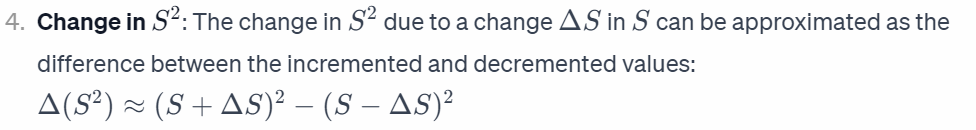

In [76]:
calib = crrCalib

S=100
r=0.03
vol=0.2
T=1
n=300

def binomialGreeks(S, r, vol, T, strike, greekType) -> float:
    trade = EuropeanOption(1, strike, PayoffType.Call)
    
    if greekType == 'Delta':
        dv = binomialPricer(S*1.001, r, vol, trade, n, calib) - binomialPricer(S*0.999, r, vol, trade, n, calib)
        ds = 2*0.1/100*S 
        delta = dv/ds
        return delta
        
    elif greekType == 'Gamma':
        dv2 = (binomialPricer(S*1.001, r, vol, trade, n, calib)
              -2*binomialPricer(S, r, vol, trade, n, calib)
              +binomialPricer(S*1.001, r, vol, trade, n, calib))
        ds2 = 1.001*S**2 - 0.999*S**2
        gamma = dv2/ds2
        return gamma
        
    elif greekType == 'Vega':
        dv = (binomialPricer(S, r, vol*1.001, trade, n, calib)
              - binomialPricer(S, r, vol*0.999, trade, n, calib))
        d_sigma = 2*vol*0.001
        vega = dv/d_sigma
        return vega
        
    elif greekType == 'Theta':
        dv = (binomialPricer(S, r, vol, trade, n, calib, trade.expiry / n + 0.004)
              - binomialPricer(S, r, vol, trade, n, calib))
        dt = 0.004
        theta = dv/dt
        return theta
    
    elif greekType == 'Rho':
        dv = (binomialPricer(S, r+0.0001, vol, trade, n, calib)
              - binomialPricer(S, r-0.0001, vol, trade, n, calib))
        dr = 2*0.0001
        rho = dv / dr
        return rho

In [77]:
df = pd.DataFrame({},index=range(50,150,1))

greekType = ['Delta','Gamma','Vega','Theta','Rho']

for greek in greekType:
    df[greek] = [binomialGreeks(S, r, vol, T, strike, greek)  for strike in range(50,150,1)]

# crrCalib

In [78]:
df

,Delta,Gamma,Vega,Theta,Rho
50,0.999902,0.009999,0.038695,876.249206,48.511848
51,0.999865,0.009999,0.052578,899.069113,49.477364
52,0.999805,0.009998,0.070925,922.440722,50.440973
53,0.999660,0.009997,0.123368,946.455762,51.401770
54,0.999542,0.009995,0.162917,971.672890,52.359038
...,...,...,...,...,...
145,0.056171,0.000562,11.367952,1311.024696,4.962174
146,0.047507,0.000475,9.833080,1279.502127,4.625746
147,0.047507,0.000475,9.917375,1247.104835,4.318474
148,0.043344,0.000467,9.069434,1215.044692,4.011237


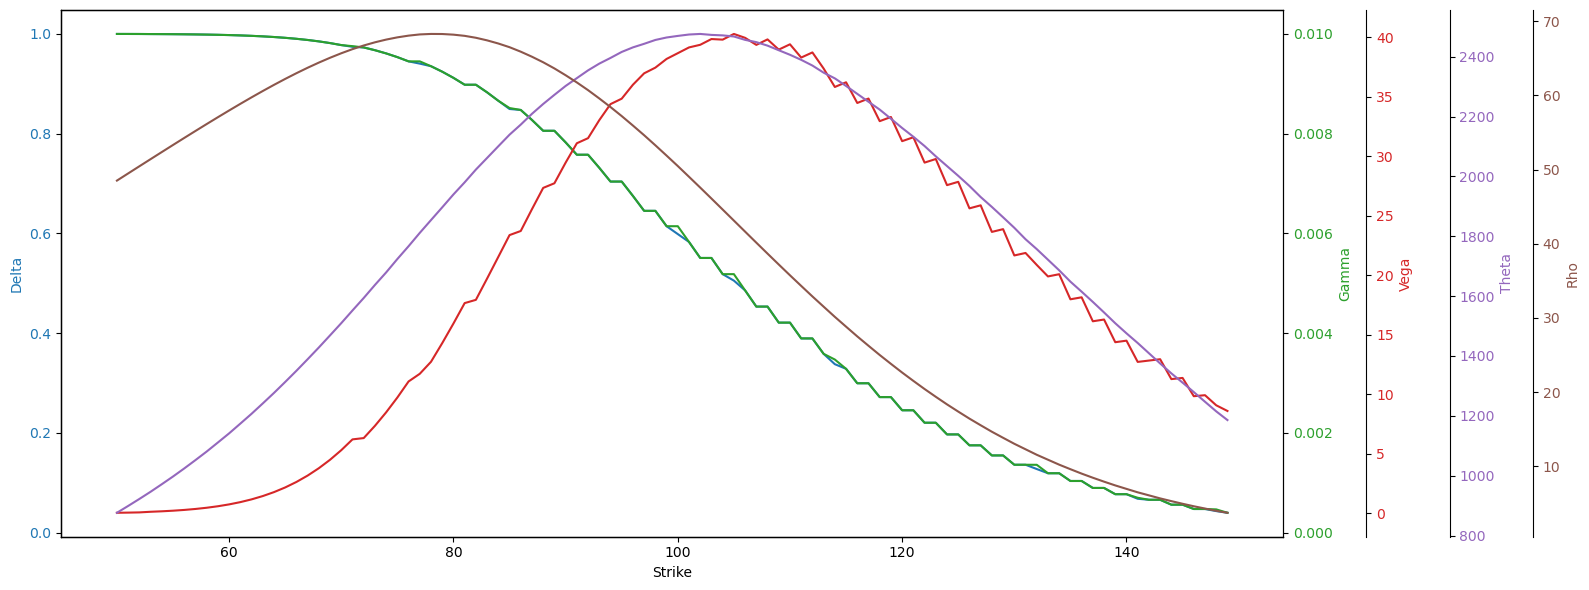

In [79]:
fig, ax1 = plt.subplots(figsize=(16,6))

color = 'tab:blue'
ax1.set_xlabel('Strike')
ax1.set_ylabel('Delta', color=color)
ax1.plot(df.index, df['Delta'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

colors = ['tab:green', 'tab:red', 'tab:purple', 'tab:brown']
for i, col in enumerate(['Gamma', 'Vega', 'Theta', 'Rho']):
    ax2 = ax1.twinx()
    ax2.set_ylabel(col, color=colors[i])
    ax2.plot(df.index, df[col], color=colors[i])
    ax2.tick_params(axis='y', labelcolor=colors[i])
    ax2.spines['right'].set_position(('outward', 60*i))  # Offset each secondary axis

fig.tight_layout()  # Adjust the layout
plt.show()

# jrrnCalib

,Delta,Gamma,Vega,Theta,Rho
50,0.999913,0.009999,0.034269,876.271522,48.513195
51,0.999837,0.009998,0.062639,899.018709,49.475641
52,0.999777,0.009998,0.083829,922.282912,50.439746
53,0.999697,0.009997,0.111427,946.469184,51.401712
54,0.999592,0.009996,0.147110,971.570190,52.360898
...,...,...,...,...,...
145,0.050737,0.000507,10.432820,1310.158493,4.650845
146,0.050737,0.000507,10.432818,1278.922807,4.682920
147,0.048049,0.000507,10.413715,1247.687122,4.714995
148,0.042761,0.000428,9.094335,1215.160266,3.944213


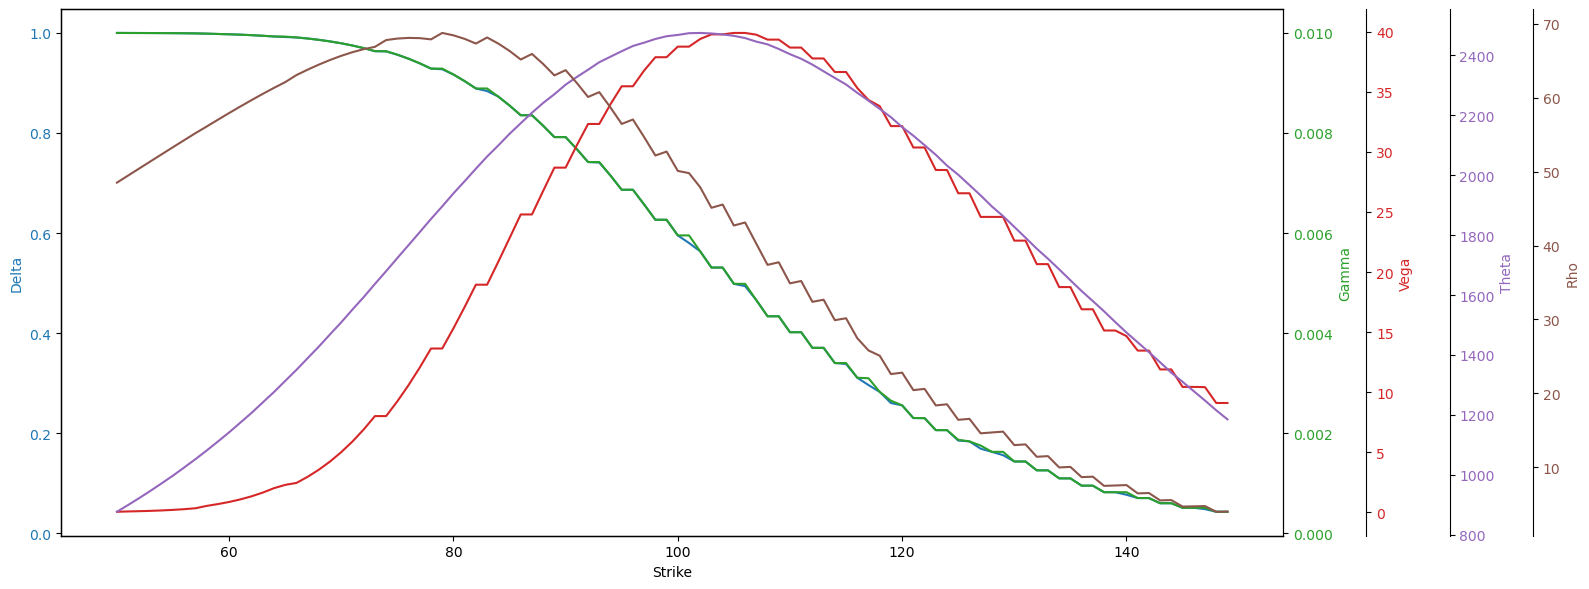

In [84]:
calib = jrrnCalib

df = pd.DataFrame({},index=range(50,150,1))

greekType = ['Delta','Gamma','Vega','Theta','Rho']

for greek in greekType:
    df[greek] = [binomialGreeks(S, r, vol, T, strike, greek)  for strike in range(50,150,1)]

display(df)

fig, ax1 = plt.subplots(figsize=(16,6))

color = 'tab:blue'
ax1.set_xlabel('Strike')
ax1.set_ylabel('Delta', color=color)
ax1.plot(df.index, df['Delta'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

colors = ['tab:green', 'tab:red', 'tab:purple', 'tab:brown']
for i, col in enumerate(['Gamma', 'Vega', 'Theta', 'Rho']):
    ax2 = ax1.twinx()
    ax2.set_ylabel(col, color=colors[i])
    ax2.plot(df.index, df[col], color=colors[i])
    ax2.tick_params(axis='y', labelcolor=colors[i])
    ax2.spines['right'].set_position(('outward', 60*i))  # Offset each secondary axis

fig.tight_layout()  # Adjust the layout
plt.show()

# jreqCalib

,Delta,Gamma,Vega,Theta,Rho
50,0.999913,0.009999,0.033824,876.213475,48.513195
51,0.999836,0.009998,0.062195,898.960758,49.475641
52,0.999777,0.009998,0.083385,922.225063,50.439746
53,0.999697,0.009997,0.110984,946.411451,51.401712
54,0.999592,0.009996,0.146667,971.512584,52.360898
...,...,...,...,...,...
145,0.050737,0.000507,10.432775,1310.140028,4.650834
146,0.050737,0.000507,10.432775,1278.904727,4.682908
147,0.048049,0.000507,10.413672,1247.669425,4.714983
148,0.042760,0.000428,9.094296,1215.142956,3.944203


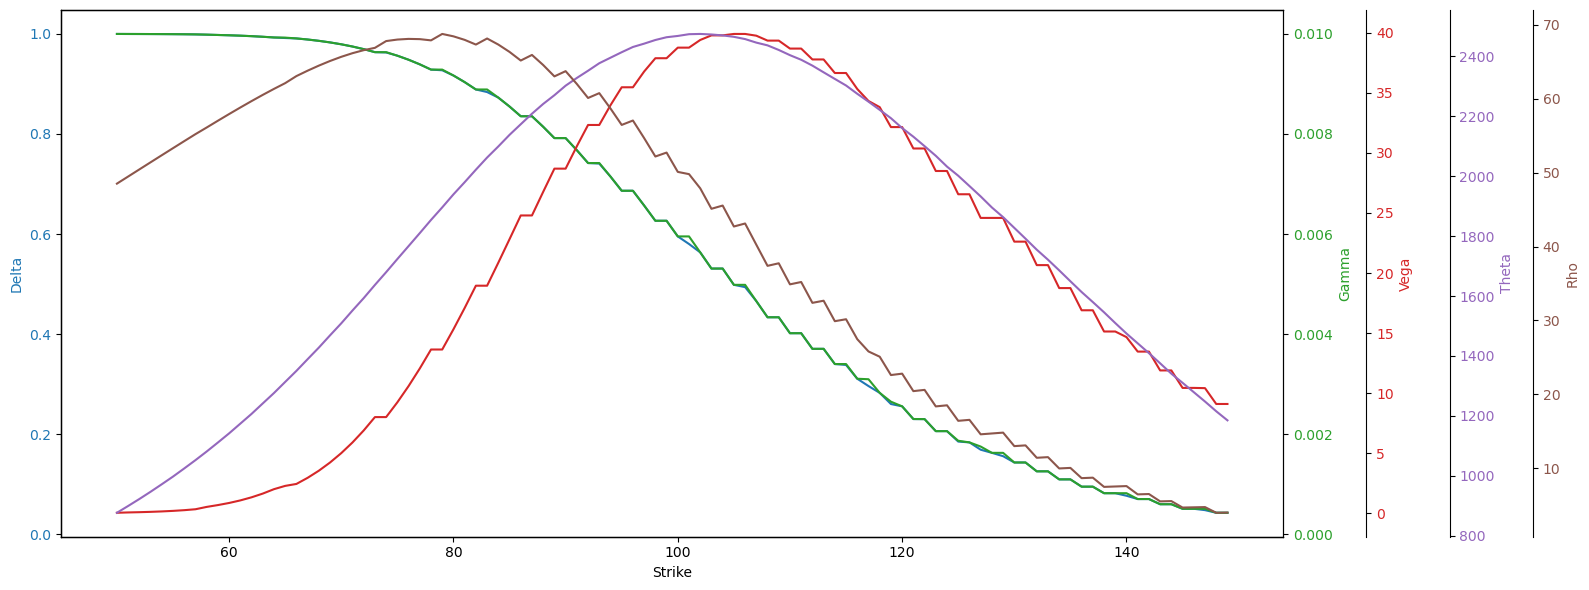

In [85]:
calib = jreqCalib

df = pd.DataFrame({},index=range(50,150,1))

greekType = ['Delta','Gamma','Vega','Theta','Rho']

for greek in greekType:
    df[greek] = [binomialGreeks(S, r, vol, T, strike, greek)  for strike in range(50,150,1)]

display(df)

fig, ax1 = plt.subplots(figsize=(16,6))

color = 'tab:blue'
ax1.set_xlabel('Strike')
ax1.set_ylabel('Delta', color=color)
ax1.plot(df.index, df['Delta'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

colors = ['tab:green', 'tab:red', 'tab:purple', 'tab:brown']
for i, col in enumerate(['Gamma', 'Vega', 'Theta', 'Rho']):
    ax2 = ax1.twinx()
    ax2.set_ylabel(col, color=colors[i])
    ax2.plot(df.index, df[col], color=colors[i])
    ax2.tick_params(axis='y', labelcolor=colors[i])
    ax2.spines['right'].set_position(('outward', 60*i))  # Offset each secondary axis

fig.tight_layout()  # Adjust the layout
plt.show()

# tianCalib

,Delta,Gamma,Vega,Theta,Rho
50,0.999894,0.009999,0.041541,876.068540,48.511173
51,0.999854,0.009999,0.056421,898.781309,49.477352
52,0.999800,0.009998,0.076064,922.187692,50.442036
53,0.999728,0.009997,0.101794,946.083512,51.404757
54,0.999589,0.009996,0.144281,971.319612,52.364919
...,...,...,...,...,...
145,0.053612,0.000536,10.893371,1311.215212,4.936699
146,0.053612,0.000536,11.006096,1279.411015,4.970746
147,0.045274,0.000453,9.480169,1246.564190,4.166829
148,0.045274,0.000453,9.577063,1215.716132,4.195175


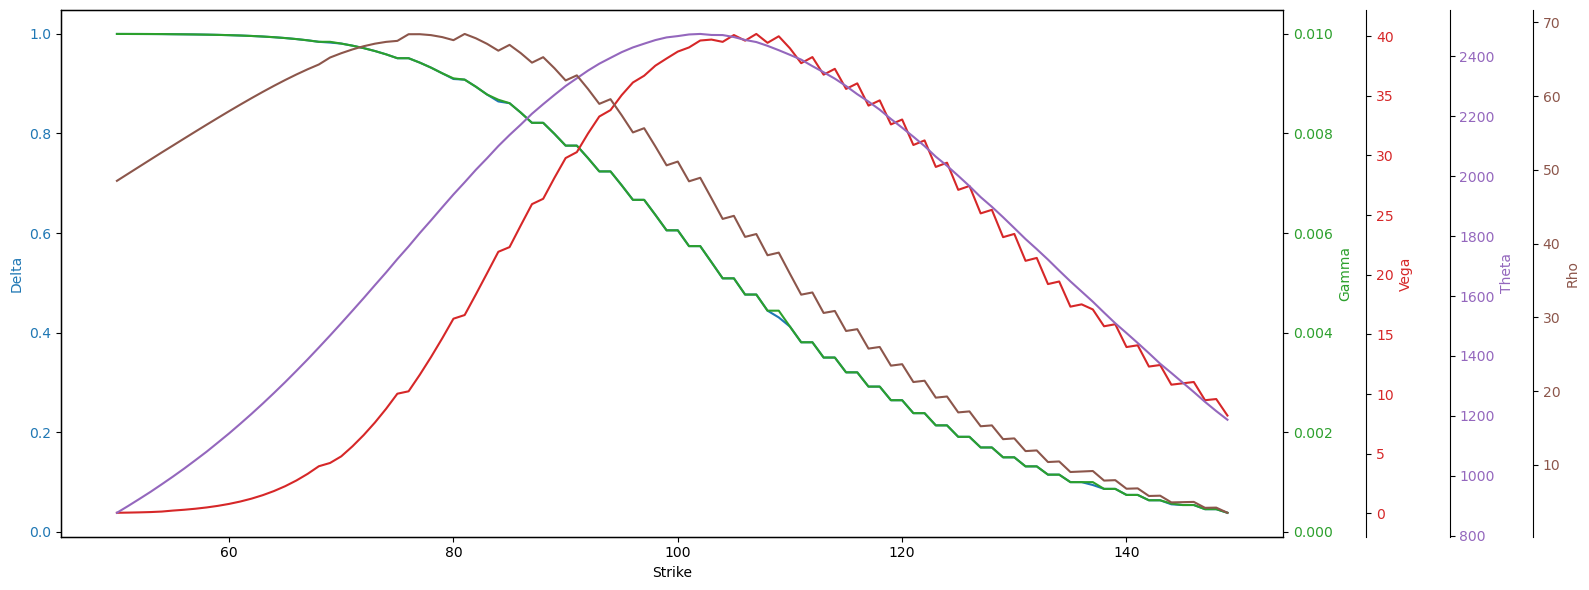

In [86]:
calib = tianCalib

df = pd.DataFrame({},index=range(50,150,1))

greekType = ['Delta','Gamma','Vega','Theta','Rho']

for greek in greekType:
    df[greek] = [binomialGreeks(S, r, vol, T, strike, greek)  for strike in range(50,150,1)]
    
display(df)
    
fig, ax1 = plt.subplots(figsize=(16,6))

color = 'tab:blue'
ax1.set_xlabel('Strike')
ax1.set_ylabel('Delta', color=color)
ax1.plot(df.index, df['Delta'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

colors = ['tab:green', 'tab:red', 'tab:purple', 'tab:brown']
for i, col in enumerate(['Gamma', 'Vega', 'Theta', 'Rho']):
    ax2 = ax1.twinx()
    ax2.set_ylabel(col, color=colors[i])
    ax2.plot(df.index, df[col], color=colors[i])
    ax2.tick_params(axis='y', labelcolor=colors[i])
    ax2.spines['right'].set_position(('outward', 60*i))  # Offset each secondary axis

fig.tight_layout()  # Adjust the layout
plt.show()